In [1]:
import torch
import torchvision.models as models

import numpy as np
import matplotlib.pyplot as plt

In [2]:
def quantize_tensor_uniformMinMax(x, num_bits=4):
    n_levels = 2**num_bits

    scale = (x.max() - x.min()) / (n_levels - 1)
    zero = -torch.round(x.min() / scale) - n_levels / 2

    x_quantized = torch.clamp(torch.round(x / scale) + zero, -n_levels, n_levels - 1)

    x_dequantized = (x_quantized - zero) * scale

    return x_quantized, x_dequantized


def quantize_tensor_PoQ(x, num_bits=4):
    """for non-negative values"""
    n_levels = 2**num_bits

    s = (x.max()) / 2 ** (n_levels - 1)

    x = x / s

    x = torch.log2(x)
    x = torch.round(x).int()
    x_quantized = torch.clamp(x, 0, n_levels - 1).int()
    # print(x_quantized.max(), x_quantized.min(), s)
    x_dequantized = 2 ** (x_quantized) * s
    return x_quantized, x_dequantized


def round_ste(x: torch.Tensor):
    """
    Implement Straight-Through Estimator for rounding operation.
    """
    return (x.round() - x).detach() + x


def lp_loss(pred, tgt, p=2.0, reduction="none"):
    """
    loss function measured in L_p Norm
    """
    if reduction == "none":
        return (pred - tgt).abs().pow(p).sum(1).mean()
    else:
        return (pred - tgt).abs().pow(p).mean()


class LogSqrt2Quantizer:
    """
    PyTorch Function that can be used for asymmetric quantization (also called uniform affine
    quantization). Quantizes its argument in the forward pass, passes the gradient 'straight
    through' on the backward pass, ignoring the quantization that occurred.
    Based on https://arxiv.org/abs/1806.08342.
    :param n_bits: number of bit for quantization
    :param channel_wise: if True, compute scale and zero_point in each channel
    """

    def __init__(
        self, n_bits: int = 4, channel_wise: bool = False, is_act: bool = False
    ):
        super(LogSqrt2Quantizer, self).__init__()
        assert 2 <= n_bits <= 8, "bitwidth not supported"
        self.n_bits = n_bits
        self.n_levels = 2**self.n_bits
        self.delta = None
        self.inited = 0
        self.maxv = None
        self.minv = None

    def forward(self, x: torch.Tensor):
        if self.inited == 0:
            self.delta = self.init_quantization_scale(x)
            # self.delta = Parameter(delta).contiguous()

            self.inited = 1

        x = x + self.delta
        x = self.logk(x, self.base)
        delta = (self.maxv - self.minv) / (self.n_levels)
        x_int = round_ste((x - self.minv) / delta)
        x_int = torch.clamp(x_int, 0, self.n_levels)
        x_float_q = self.base ** round_ste((x_int * delta + self.minv))
        x_dequant = x_float_q - self.delta

        return x_int, x_dequant

    def init_quantization_scale(self, x: torch.Tensor):
        x_clone = x.clone().detach()
        cur_bias = -10
        self.base = 2
        best_score = 1e10
        for bias in [0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.5, 1.0]:
            x_q, maxv, minv = self.quantize(x_clone, bias)
            score = lp_loss(x_clone, x_q, p=2, reduction="all")
            if score < best_score:
                best_score = score
                cur_bias = bias
                self.maxv = maxv
                self.minv = minv
        return torch.tensor(cur_bias)

    def logk(self, x, k):
        natural_log = torch.log(x)
        log_k = natural_log / torch.log(torch.tensor(k, dtype=x.dtype))
        return log_k

    def quantize(self, x, bias):

        x = x + bias
        x = self.logk(x, self.base)
        maxv = torch.max(x)
        minv = torch.min(x)

        delta = (maxv - minv) / (self.n_levels - 1)
        x_int = round_ste((x - minv) / delta)
        x_int = torch.clamp(x_int, 0, self.n_levels - 1)
        # x_int = torch.clamp(x_int, 0, self.n_levels)
        x_float_q = self.base ** torch.round((x_int * delta + minv))
        x_float_q = x_float_q - bias

        return x_float_q, maxv, minv


def drawHist(input, bits=4, non_negative=True):
    x = input
    quant, dequant = quantize_tensor_uniformMinMax(x, num_bits=4)
    # logquant, logdequant = log2_quantization(x, num_bits=4)

    print(f"L2 distance with UniformAffineQuantizerMinMax: {torch.norm(x - dequant, p=2)}")
    fig, axes = None, None
    if non_negative == False:
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    else:
        fig, axes = plt.subplots(3, 3, figsize=(15, 15))

    axes[0][0].hist(x, bins=100)
    axes[0][0].set_yscale("log")
    axes[0][0].set_title("Original Data")
    axes[0][1].hist(quant, bins=2**bits)
    axes[0][1].set_title("UniformAffineQuantizerMinMax")
    axes[0][2].hist(dequant, bins=100)
    axes[0][2].set_title("UniformAffineQuantizerMinMax")
    axes[0][2].set_yscale("log")

    quant, dequant = quantize_tensor_PoQ(x, num_bits=bits)

    axes[1][0].hist(x, bins=100)
    axes[1][0].set_yscale("log")
    axes[1][0].set_title("Original Data")
    axes[1][1].hist(quant, bins=2**bits)
    axes[1][1].set_title("PoQ")
    axes[1][2].hist(dequant, bins=100)
    axes[1][2].set_title("PoQ")
    axes[1][2].set_yscale("log")
    print(f"L2 distance with PoQ: {torch.norm(x - dequant, p=2)}")
    PoQquant = quant

    if non_negative == False:
        pass
    else:
        dja = LogSqrt2Quantizer(n_bits=bits)
        reflogquant, reflogdequant = dja.forward(x)

        axes[2][0].hist(x, bins=100)
        axes[2][0].set_yscale("log")
        axes[2][0].set_title("Original Data")
        axes[2][1].hist(reflogquant, bins=2**bits)
        axes[2][1].set_title("LogSqrt2Quantizer")
        axes[2][2].hist(reflogdequant, bins=100)
        axes[2][2].set_title("LogSqrt2Quantizer")
        axes[2][2].set_yscale("log")
        print(
            f"L2 distance with LogSqrt2Quantizer: {torch.norm(x - reflogdequant, p=2)}"
        )

    plt.show()

In [3]:
import torchvision.transforms as transforms, torchvision.datasets as datasets
def GetDataset(
    dataset_name: str,
    device: str,
    root: str = "data",
    batch_size: int = 128,
    num_workers: int = 8,
) -> tuple[torch.utils.data.DataLoader, torch.utils.data.DataLoader]:
    """Get the dataset and dataloader

    Args:
        dataset_name (str): {"CIFAR10", "CIFAR100", "ImageNet"}
        device (str): {"cpu", "cuda:0", ...}
        root (str, optional): The root folder of datasets. Defaults to "data".
        batch_size (int, optional): Size of Batch. Defaults to 128.
        num_workers (int, optional): Num of Workers about Dataloader. Defaults to 8.

    Returns:
        tuple: trainloader, testloader
    """
    if dataset_name == "CIFAR10" or dataset_name == "CIFAR100":
        pass
    # Load the CIFAR-100 dataset
    elif dataset_name == "ImageNet":
        train_dataset = datasets.ImageNet(
            root=root + "/ImageNet",
            split="train",
            transform=transforms.Compose(
                [
                    transforms.Resize(232),
                    transforms.CenterCrop(224),
                    # transforms.RandomResizedCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(
                        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                    ),
                ]
            ),
        )
        test_dataset = datasets.ImageNet(
            root=root + "/ImageNet",
            split="val",
            transform=transforms.Compose(
                [
                    # transforms.Resize(256),
                    transforms.Resize(232),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    transforms.Normalize(
                        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                    ),
                ]
            ),
        )
    if device == "cpu":
        train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
        )
        test_loader = torch.utils.data.DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
        )
    else:
        train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
            pin_memory=True,
            pin_memory_device=device,
        )
        test_loader = torch.utils.data.DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=True,
            pin_memory_device=device,
        )
    return train_loader, test_loader

In [4]:
# Pretrained ResNet50 모델 로드
model = models.resnet18(weights="DEFAULT")


In [5]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
for name, module in model.named_modules():
    print(name)


conv1
bn1
relu
maxpool
layer1
layer1.0
layer1.0.conv1
layer1.0.bn1
layer1.0.relu
layer1.0.conv2
layer1.0.bn2
layer1.1
layer1.1.conv1
layer1.1.bn1
layer1.1.relu
layer1.1.conv2
layer1.1.bn2
layer2
layer2.0
layer2.0.conv1
layer2.0.bn1
layer2.0.relu
layer2.0.conv2
layer2.0.bn2
layer2.0.downsample
layer2.0.downsample.0
layer2.0.downsample.1
layer2.1
layer2.1.conv1
layer2.1.bn1
layer2.1.relu
layer2.1.conv2
layer2.1.bn2
layer3
layer3.0
layer3.0.conv1
layer3.0.bn1
layer3.0.relu
layer3.0.conv2
layer3.0.bn2
layer3.0.downsample
layer3.0.downsample.0
layer3.0.downsample.1
layer3.1
layer3.1.conv1
layer3.1.bn1
layer3.1.relu
layer3.1.conv2
layer3.1.bn2
layer4
layer4.0
layer4.0.conv1
layer4.0.bn1
layer4.0.relu
layer4.0.conv2
layer4.0.bn2
layer4.0.downsample
layer4.0.downsample.0
layer4.0.downsample.1
layer4.1
layer4.1.conv1
layer4.1.bn1
layer4.1.relu
layer4.1.conv2
layer4.1.bn2
avgpool
fc


In [7]:
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        print(name)
    if isinstance(module, torch.nn.Linear):
        print(name)
        
        

conv1
layer1.0.conv1
layer1.0.conv2
layer1.1.conv1
layer1.1.conv2
layer2.0.conv1
layer2.0.conv2
layer2.0.downsample.0
layer2.1.conv1
layer2.1.conv2
layer3.0.conv1
layer3.0.conv2
layer3.0.downsample.0
layer3.1.conv1
layer3.1.conv2
layer4.0.conv1
layer4.0.conv2
layer4.0.downsample.0
layer4.1.conv1
layer4.1.conv2
fc


In [8]:
train_loader, test_loader = GetDataset("ImageNet", "cuda:0", batch_size=1, num_workers=8)

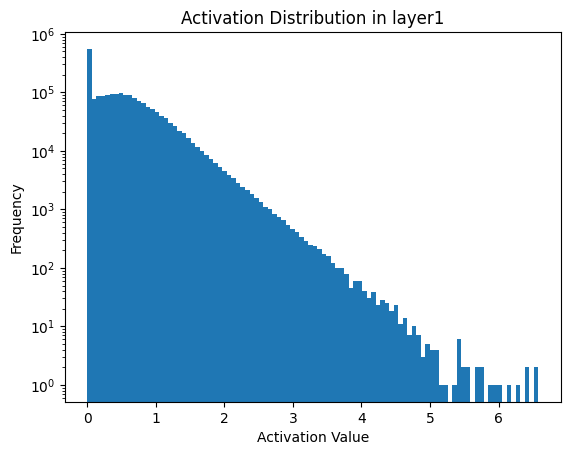

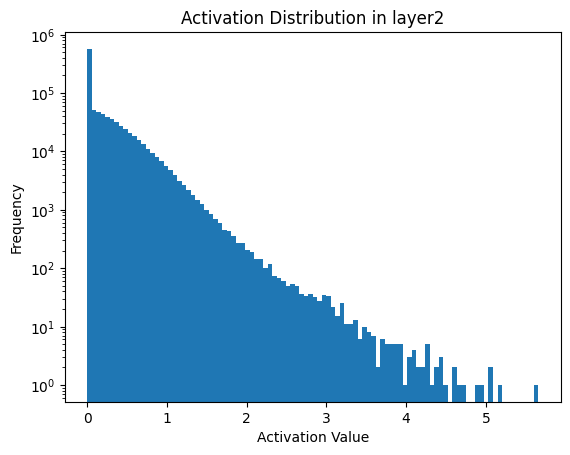

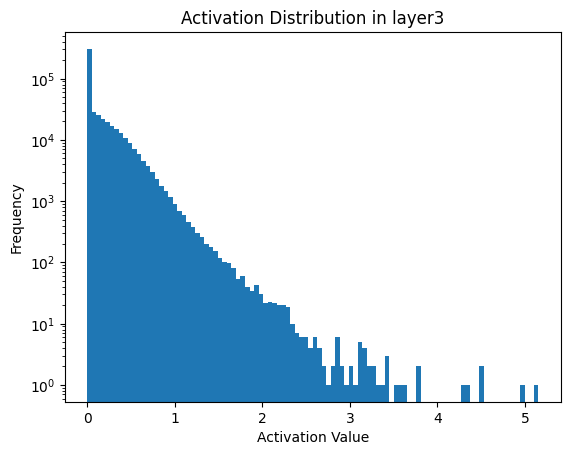

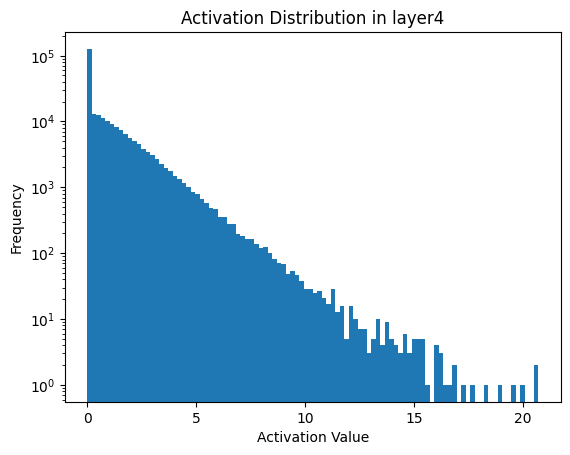

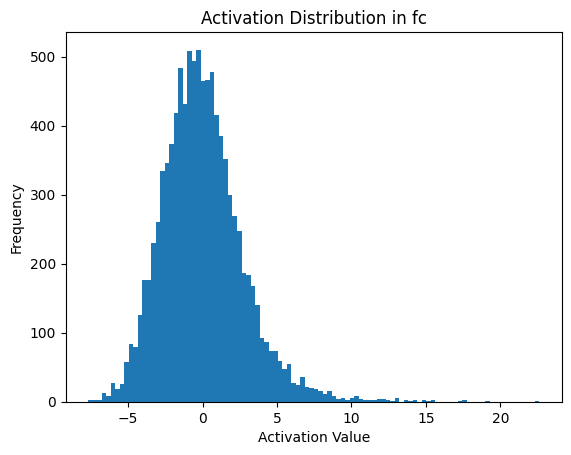

In [9]:
# 각 레이어의 활성화 저장을 위한 변수
activations = {"layer1": [], "layer2": [], "layer3": [], "layer4": [], "fc": []}


# Forward hook 함수 정의
def get_activation(name):
    def hook(model, input, output):
        activations[name].append(output.detach().cpu())

    return hook


# Hook 등록
hooks = []
hooks.append(model.layer1.register_forward_hook(get_activation("layer1")))
hooks.append(model.layer2.register_forward_hook(get_activation("layer2")))
hooks.append(model.layer3.register_forward_hook(get_activation("layer3")))
hooks.append(model.layer4.register_forward_hook(get_activation("layer4")))
hooks.append(model.fc.register_forward_hook(get_activation("fc")))

# 모델을 평가 모드로 전환
model.eval()

# 몇 개의 배치를 통해 활성화 추출
with torch.no_grad():
    for i, (images, labels) in enumerate(train_loader):
        if i >= 10:  # 예시로 100개의 이미지만 사용
            break
        _ = model(images)

# Hook 제거
for hook in hooks:
    hook.remove()


# 활성화 배열을 하나로 합침 및 히스토그램 그리기 함수
def plot_hist(layer_name, logScale=False):
    all_activations = torch.concatenate(activations[layer_name], axis=0)
    plt.hist(all_activations.flatten(), bins=100)
    plt.title(f"Activation Distribution in {layer_name}")
    plt.xlabel("Activation Value")
    plt.ylabel("Frequency")
    if logScale:
        plt.yscale("log")
    plt.show()


# 다른 레이어 활성화 분포 히스토그램 (예시로 layer1)
plot_hist("layer1", logScale = True)
plot_hist("layer2", logScale = True)
plot_hist("layer3", logScale = True)
plot_hist("layer4", logScale = True)
# FC 레이어 활성화 분포 히스토그램
plot_hist("fc")

L2 distance with UniformAffineQuantizerMinMax: 157.33395385742188
L2 distance with PoQ: 212.304931640625
L2 distance with LogSqrt2Quantizer: 247.118896484375


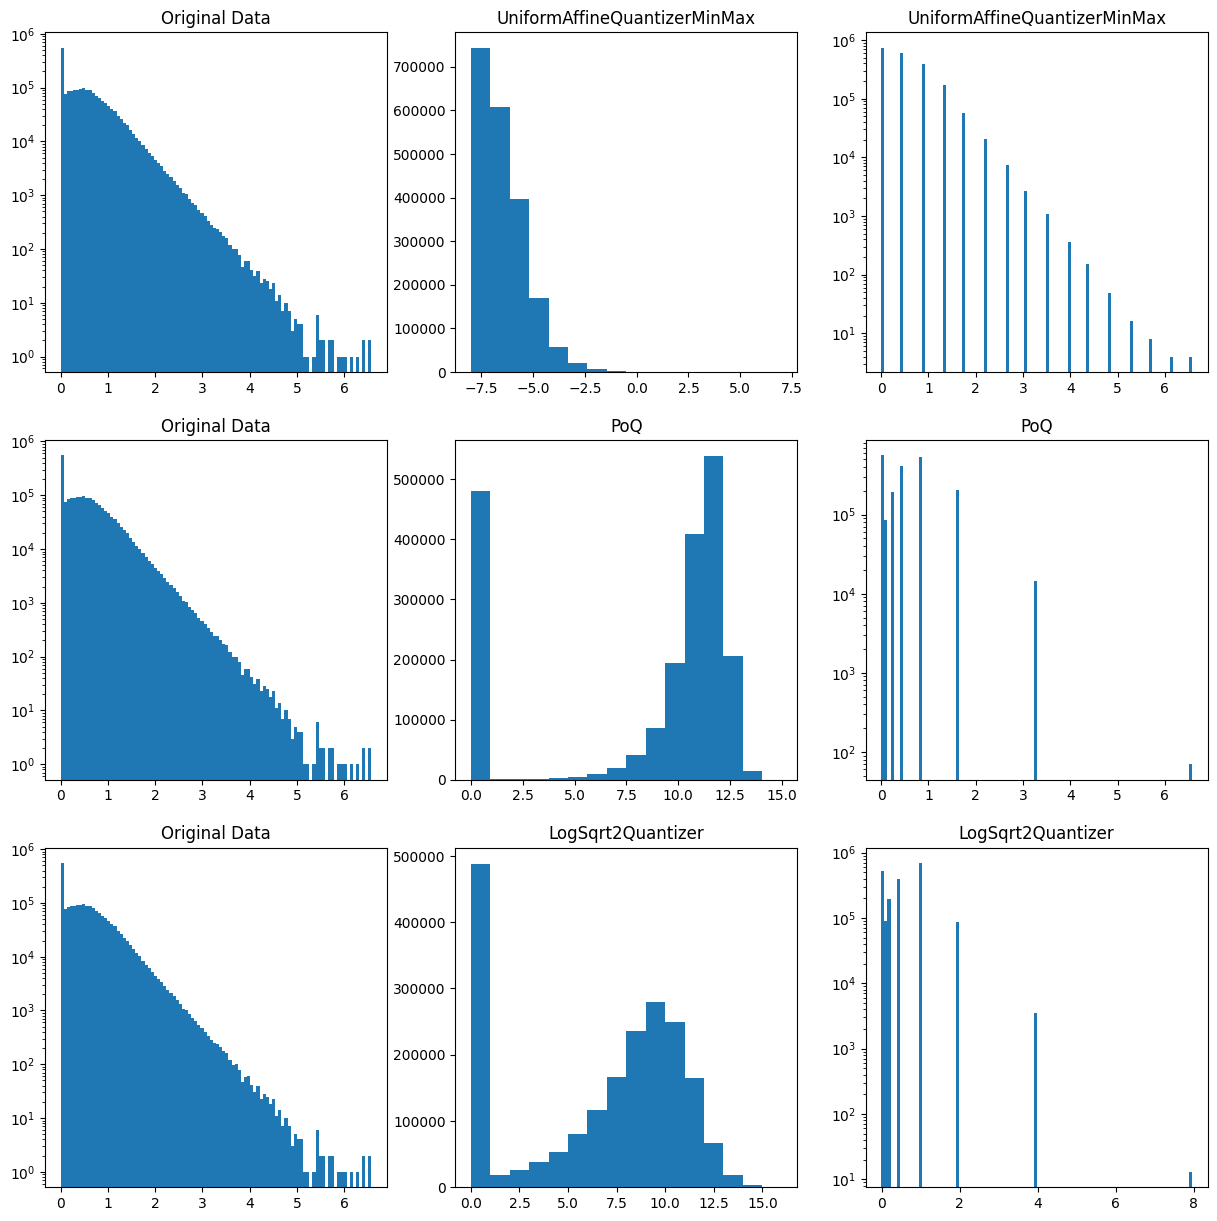

In [10]:
drawHist(
    torch.concatenate(activations["layer1"], axis=0).flatten(), bits=4, non_negative=True
)

L2 distance with UniformAffineQuantizerMinMax: 75.94929504394531
L2 distance with PoQ: 74.84517669677734
L2 distance with LogSqrt2Quantizer: 79.86067199707031


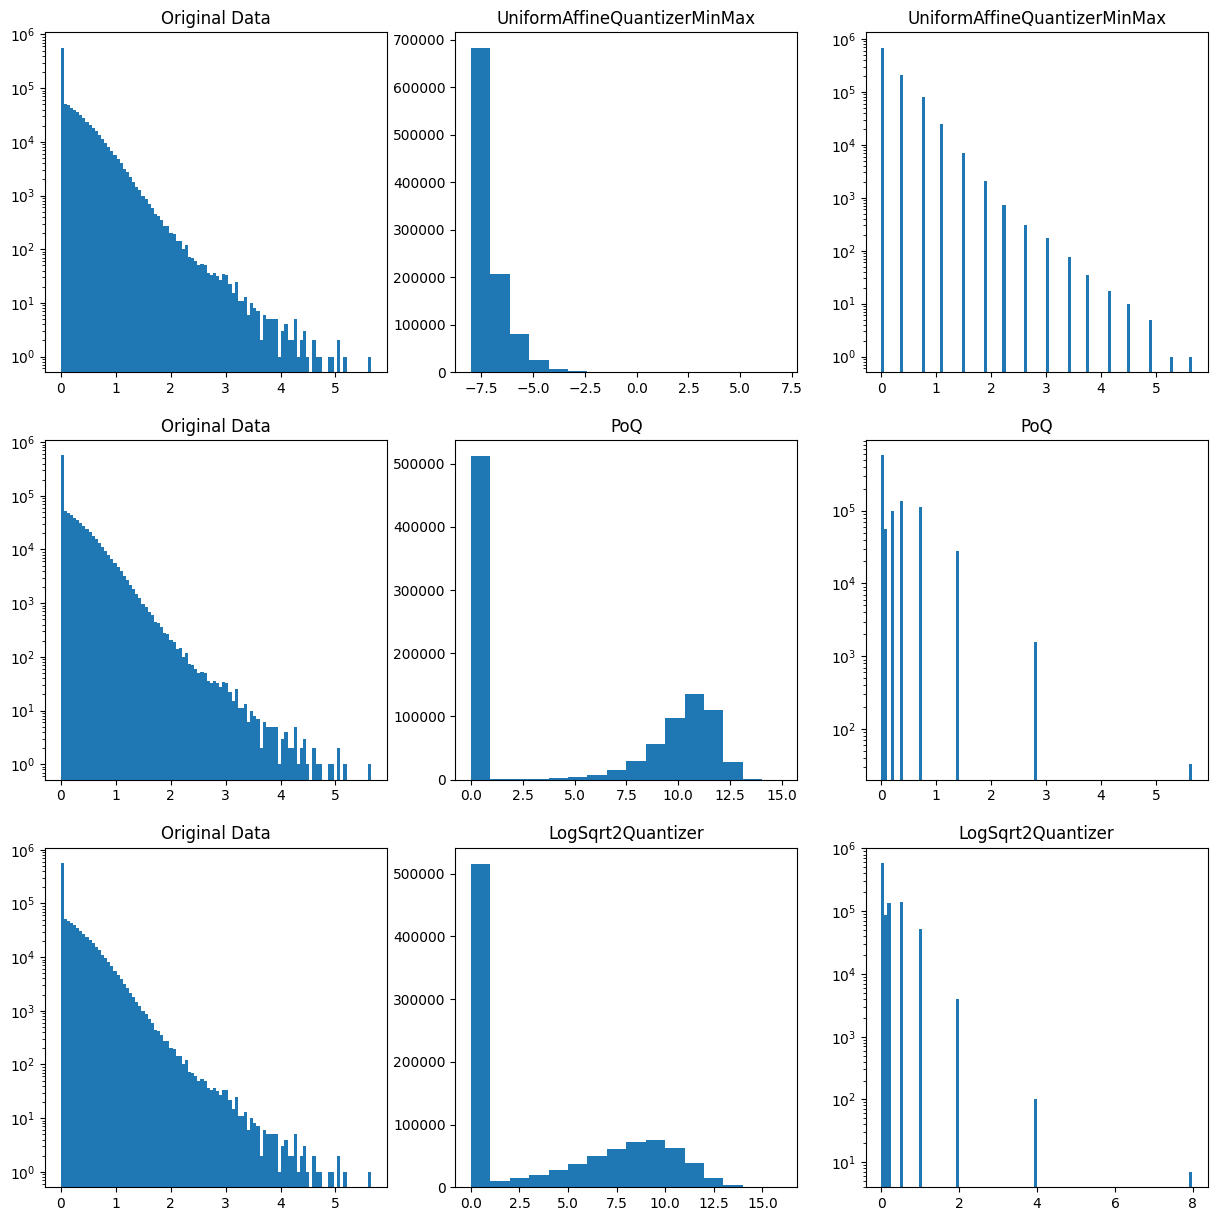

In [11]:
drawHist(
    torch.concatenate(activations["layer2"], axis=0).flatten(),
    bits=4,
    non_negative=True,
)

L2 distance with UniformAffineQuantizerMinMax: 46.728397369384766
L2 distance with PoQ: 38.13630676269531
L2 distance with LogSqrt2Quantizer: 51.2224235534668


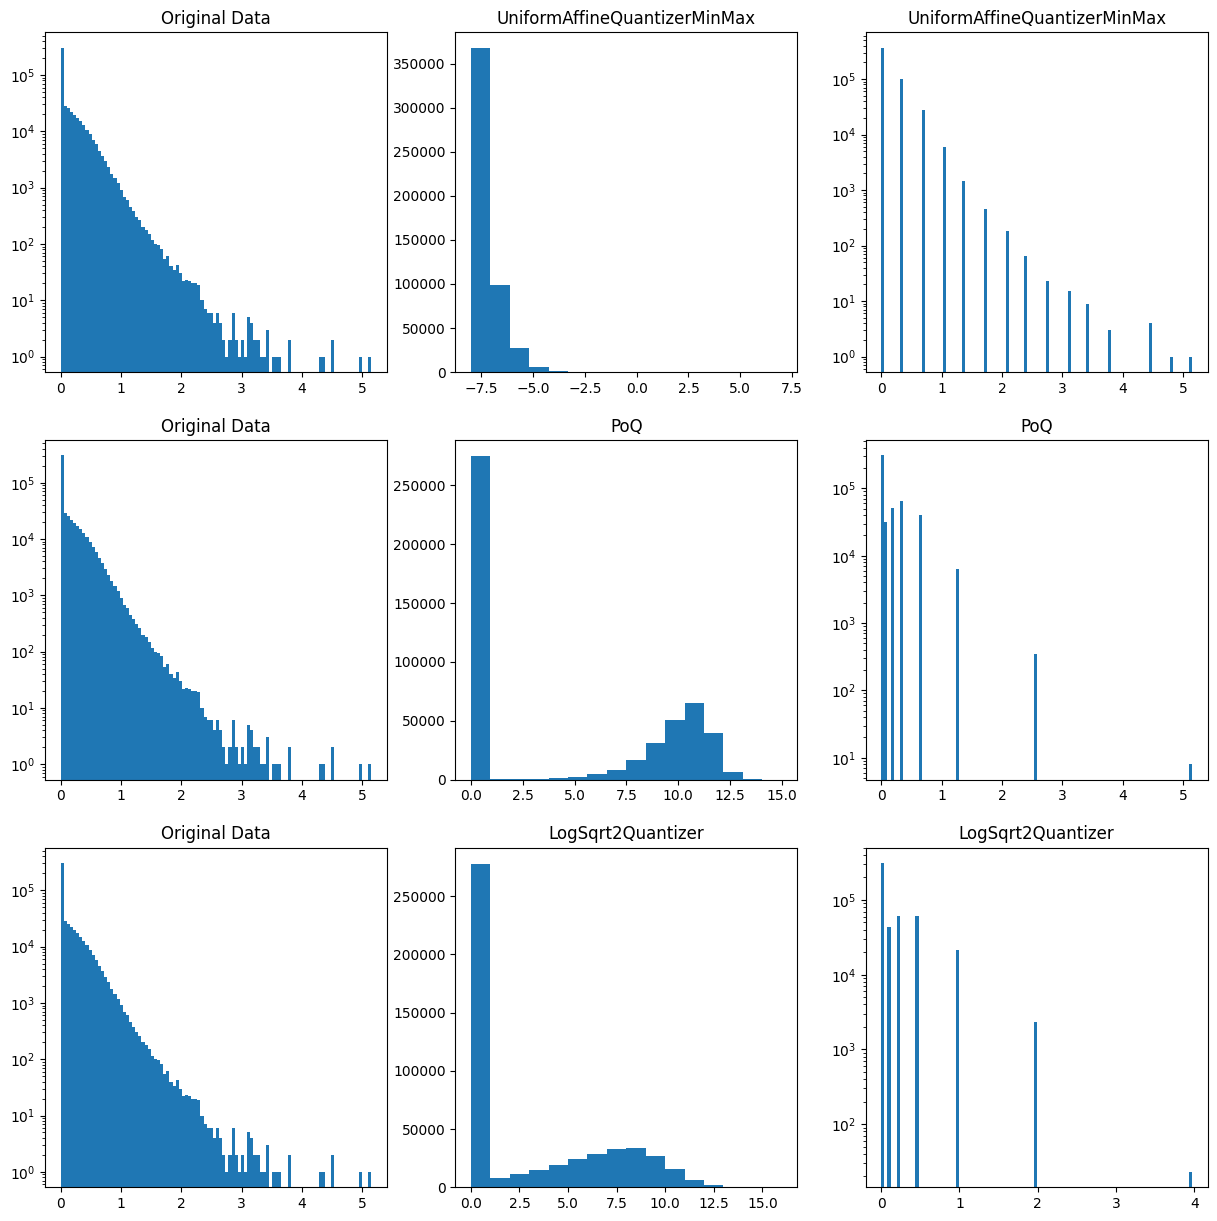

In [12]:
drawHist(
    torch.concatenate(activations["layer3"], axis=0).flatten(),
    bits=4,
    non_negative=True,
)

L2 distance with UniformAffineQuantizerMinMax: 148.02325439453125
L2 distance with PoQ: 177.0054473876953
L2 distance with LogSqrt2Quantizer: 196.63735961914062


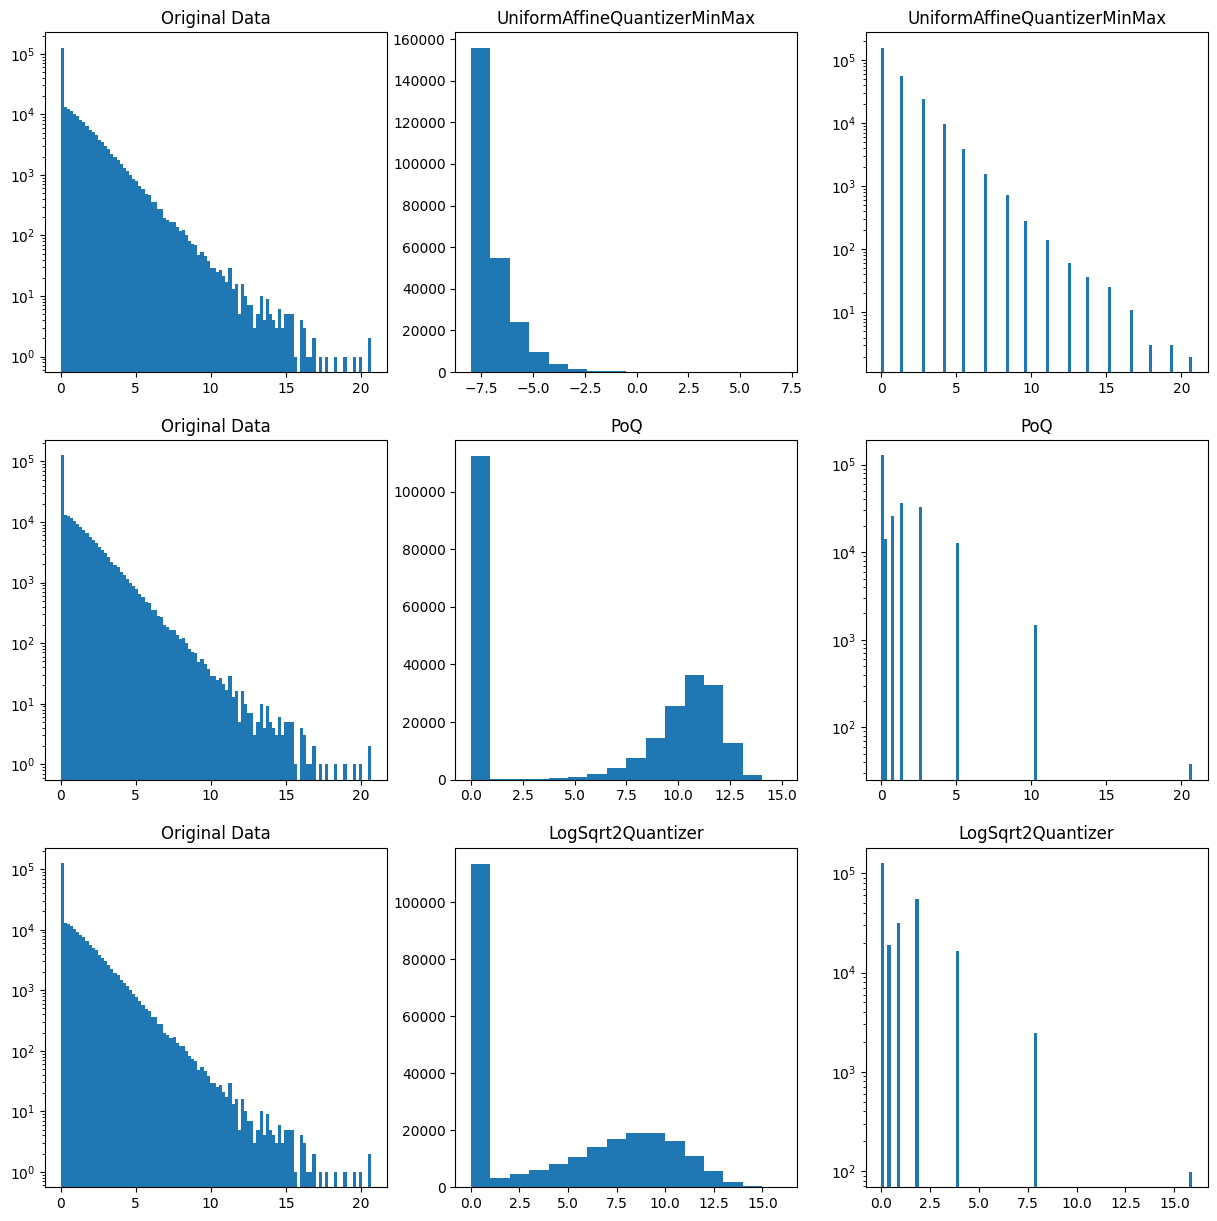

In [13]:
drawHist(
    torch.concatenate(activations["layer4"], axis=0).flatten(),
    bits=4,
    non_negative=True,
)

L2 distance with UniformAffineQuantizerMinMax: 58.20991516113281
L2 distance with PoQ: 179.44566345214844


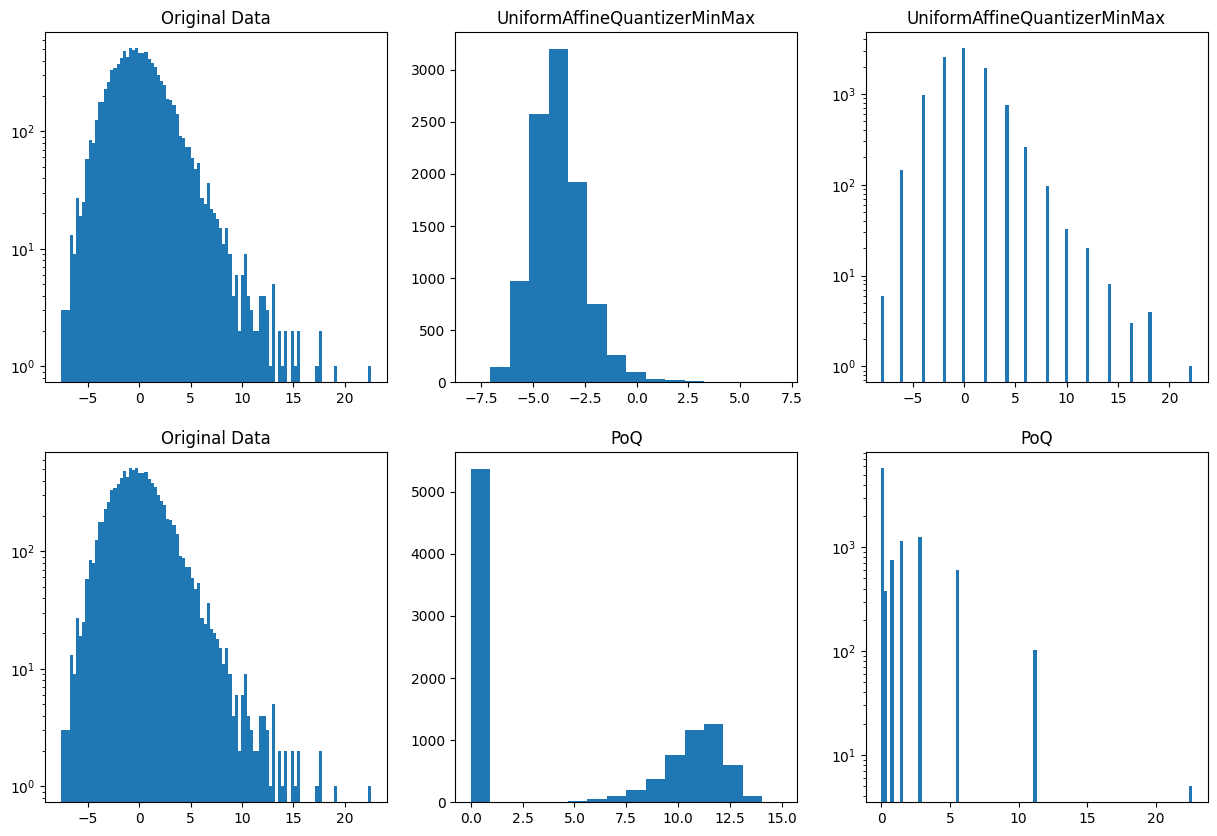

In [14]:
drawHist(
    torch.concatenate(activations["fc"], axis=0).flatten(), bits=4, non_negative=False
)